In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi

In [2]:
# Define the exact solution u = H
def exact_solution_h(x, y, t):
    return -torch.sin(x)*torch.sin(y)*torch.cos(t)

def initial_condition_h(x, y):
    return -torch.sin(x)*torch.sin(y) 

In [3]:
# Define the exact solution p = E
def exact_solution_e1(x, y, t):
    return -torch.sin(x)*torch.sin(t)*torch.cos(y)

def initial_condition_e1(x, y):
    return 0.0*torch.sin(x) 

In [4]:
# Define the exact solution p = E
def exact_solution_e2(x, y, t):
    return torch.sin(y)*torch.sin(t)*torch.cos(x)

def initial_condition_e2(x, y):
    return 0.0*torch.sin(x) 

In [5]:
# assigning number of points
initial_pts = 200 
left_boundary_pts = 200 
right_boundary_pts = 200
back_boundary_pts = 200
front_boundary_pts = 200
residual_pts = 1000

In [6]:
# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

x_init = torch.rand((initial_pts,1)) # initial pts
y_init = torch.rand((initial_pts,1))
t_init =  0*x_init
init =  torch.cat([x_init, y_init, t_init],1)
h_init = initial_condition_h(init[:,0], init[:, 1]).reshape(-1, 1)
e1_init = initial_condition_e1(init[:,0], init[:, 1]).reshape(-1, 1)
e2_init = initial_condition_e2(init[:,0], init[:, 1]).reshape(-1, 1)
w_init = torch.cat([h_init, e1_init, e2_init],1)


xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
yb_left = torch.rand((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) # 
b_left = torch.cat([xb_left, yb_left, tb_left ],1)
h_b_l = exact_solution_h(xb_left, yb_left, tb_left).reshape(-1, 1)
e1_b_l = exact_solution_e1(xb_left, yb_left, tb_left).reshape(-1, 1)
e2_b_l = exact_solution_e2(xb_left, yb_left, tb_left).reshape(-1, 1)



xb_right = torch.ones((right_boundary_pts, 1)) # right spatial boundary
yb_right = torch.rand((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, yb_right, tb_right ],1)
h_b_r = exact_solution_h(xb_right, yb_right, tb_right).reshape(-1, 1)
e1_b_r = exact_solution_e1(xb_right, yb_right, tb_right).reshape(-1, 1)
e2_b_r = exact_solution_e2(xb_right, yb_right, tb_right).reshape(-1, 1)



xb_front = torch.rand((front_boundary_pts, 1)) # front spatial boundary
yb_front = torch.zeros((front_boundary_pts, 1)) # front spatial boundary
tb_front = torch.rand((front_boundary_pts, 1)) # 
b_front = torch.cat([xb_front, yb_front, tb_front ],1)
h_b_f = exact_solution_h(xb_front, yb_front, tb_front).reshape(-1, 1)
e1_b_f = exact_solution_e1(xb_front, yb_front, tb_front).reshape(-1, 1)
e2_b_f = exact_solution_e2(xb_front, yb_front, tb_front).reshape(-1, 1)



xb_back = torch.rand((back_boundary_pts, 1)) # back spatial boundary
yb_back = torch.ones((back_boundary_pts, 1)) # back spatial boundary
tb_back = torch.rand((back_boundary_pts, 1)) # back boundary pts
b_back = torch.cat([xb_back, yb_back, tb_back ],1)
h_b_b = exact_solution_h(xb_back, yb_back, tb_back).reshape(-1, 1)
e1_b_b = exact_solution_e1(xb_back, yb_back, tb_back).reshape(-1, 1)
e2_b_b = exact_solution_e2(xb_back, yb_back, tb_back).reshape(-1, 1)



x_interior = torch.rand((residual_pts, 1))
y_interior = torch.rand((residual_pts, 1))
t_interior = torch.rand((residual_pts, 1))
interior = torch.cat([x_interior, y_interior, t_interior],1)





training_set = DataLoader(torch.utils.data.TensorDataset(init, w_init, b_left,  b_right, b_front, b_back), batch_size=200, shuffle=False)

In [7]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)


In [8]:
# Model definition
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = w_init.shape[1], n_hidden_layers=4, neurons=20)


In [9]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)
#print(my_network(init))

In [10]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

In [11]:
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (initial, w_initial, bd_left,  bd_right, bd_front, bd_back) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                w_initial_pred_ = model(initial)
                h_initial_pred_ = w_initial_pred_[:,0].reshape(-1,1)
                e1_initial_pred_ = w_initial_pred_[:,1].reshape(-1,1)
                e2_initial_pred_ = w_initial_pred_[:,2].reshape(-1,1)
                
                
                # with derivative
                inpu = torch.ones(initial_pts, 1 )
                
                grad_h_ini = torch.autograd.grad(h_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                h_initial_t = grad_h_ini[:, 2]
                
                grad_e1_ini = torch.autograd.grad(e1_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                e1_initial_t = grad_e1_ini[:, 2]
                
                grad_e2_ini = torch.autograd.grad(e2_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                e2_initial_t = grad_e2_ini[:, 2]
                
                
                
                # for left boundary
                w_bd_left_pred_ = model(bd_left)
                h_bd_left_pred_ = w_bd_left_pred_[:,0].reshape(-1,1)
                e1_bd_left_pred_ = w_bd_left_pred_[:,1].reshape(-1,1)
                e2_bd_left_pred_ = w_bd_left_pred_[:,2].reshape(-1,1)
                
                # for right boundary
                w_bd_right_pred_ = model(bd_right)
                h_bd_right_pred_ = w_bd_right_pred_[:,0].reshape(-1,1)
                e1_bd_right_pred_ = w_bd_right_pred_[:,1].reshape(-1,1)
                e2_bd_right_pred_ = w_bd_right_pred_[:,2].reshape(-1,1)
                
                # for front boundary
                w_bd_front_pred_ = model(bd_front)
                h_bd_front_pred_ = w_bd_front_pred_[:,0].reshape(-1,1)
                e1_bd_front_pred_ = w_bd_front_pred_[:,1].reshape(-1,1)
                e2_bd_front_pred_ = w_bd_front_pred_[:,2].reshape(-1,1)
                
                # for back boundary
                w_bd_back_pred_ = model(bd_back)
                h_bd_back_pred_ = w_bd_back_pred_[:,0].reshape(-1,1)
                e1_bd_back_pred_ = w_bd_back_pred_[:,1].reshape(-1,1)
                e2_bd_back_pred_ = w_bd_back_pred_[:,2].reshape(-1,1)
                
                # residual calculation
                interior.requires_grad = True
                w_hat = model(interior)
                h_hat = w_hat[:,0].reshape(-1,1)
                e1_hat = w_hat[:,1].reshape(-1,1)
                e2_hat = w_hat[:,2].reshape(-1,1)
                
                inputs = torch.ones(residual_pts, 1 )
                inputs2 = torch.ones(residual_pts, 1)
                
                grad_h_hat = torch.autograd.grad(h_hat.reshape(-1,1), interior, grad_outputs=inputs, create_graph=True)[0]
                h_x = grad_h_hat[:, 0].reshape(-1,1)
                h_y = grad_h_hat[:, 1].reshape(-1,1)
                
                grad_e1_hat = torch.autograd.grad(e1_hat, interior, grad_outputs=inputs, create_graph=True)[0]
                e1_x = grad_e1_hat[:, 0].reshape(-1,1)
                e1_y = grad_e1_hat[:, 1].reshape(-1,1)
                
                grad_e2_hat = torch.autograd.grad(e2_hat, interior, grad_outputs=inputs, create_graph=True)[0]
                e2_x = grad_e2_hat[:, 0].reshape(-1,1)
                e2_y = grad_e2_hat[:, 1].reshape(-1,1)
                
                h_t = grad_h_hat[:, 2].reshape(-1,1)
                e1_t = grad_e1_hat[:, 2].reshape(-1,1)
                e2_t = grad_e2_hat[:, 2].reshape(-1,1)
                
                
                # Item 1. below
                loss1 = torch.mean((h_initial_pred_.reshape(-1, ) - w_initial[:,0].reshape(-1, ))**p) + torch.mean((2*h_t.reshape(-1, ) + e2_x.reshape(-1, ) - e1_y.reshape(-1, ))**p)+torch.mean((h_bd_left_pred_.reshape(-1,)- h_b_l.reshape(-1,))**p) + torch.mean((h_bd_right_pred_.reshape(-1,)- h_b_r.reshape(-1,))**p) +torch.mean((h_bd_front_pred_.reshape(-1,)- h_b_f.reshape(-1,))**p) + torch.mean((h_bd_back_pred_.reshape(-1,)- h_b_b.reshape(-1,))**p)
                loss2 = torch.mean((e1_initial_pred_.reshape(-1, ) - w_initial[:,1].reshape(-1, ))**p)+ torch.mean((4*e1_t.reshape(-1, ) + 2*torch.cos(interior[:, 0])*torch.cos(interior[:, 2])*torch.sin(interior[:, 1]) - h_y.reshape(-1, ) + 3*torch.sin(interior[:, 0])*torch.cos(interior[:, 2])*torch.cos(interior[:, 1]) - 2*torch.cos(interior[:, 0])*torch.cos(interior[:, 2])*torch.sin(interior[:, 1]) )**p) +torch.mean((e1_bd_left_pred_.reshape(-1,)- e1_b_l.reshape(-1,))**p) + torch.mean((e1_bd_right_pred_.reshape(-1,)- e1_b_r.reshape(-1,))**p) +torch.mean((e1_bd_front_pred_.reshape(-1,)- e1_b_f.reshape(-1,))**p) + torch.mean((e1_bd_back_pred_.reshape(-1,)- e1_b_b.reshape(-1,))**p)
                loss3 = torch.mean((e2_initial_pred_.reshape(-1, ) - w_initial[:,2].reshape(-1, ))**p)+ torch.mean((-2*torch.sin(interior[:, 0])*torch.cos(interior[:, 2])*torch.cos(interior[:, 1]) + e2_t.reshape(-1, )  + h_x.reshape(-1, ) + 2*torch.sin(interior[:, 0])*torch.cos(interior[:, 2])*torch.cos(interior[:, 1]))**p) +torch.mean((e2_bd_left_pred_.reshape(-1,)- e2_b_l.reshape(-1,))**p) + torch.mean((e2_bd_right_pred_.reshape(-1,)- e2_b_r.reshape(-1,))**p) +torch.mean((e2_bd_front_pred_.reshape(-1,)- e2_b_f.reshape(-1,))**p) + torch.mean((e2_bd_back_pred_.reshape(-1,)- e2_b_b.reshape(-1,))**p)
                loss = loss1 + loss2 + loss3
                
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [12]:
n_epochs = 1500
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )

################################  0  ################################
Loss:  137.0339813232422
################################  1  ################################
Loss:  134.1363067626953
################################  2  ################################
Loss:  113.90143585205078
################################  3  ################################
Loss:  89.89928436279297
################################  4  ################################
Loss:  66.98069763183594
################################  5  ################################
Loss:  53.799625396728516
################################  6  ################################
Loss:  45.88216781616211
################################  7  ################################
Loss:  40.06132888793945
################################  8  ################################
Loss:  35.32625198364258
################################  9  ################################
Loss:  31.256216049194336
################################  10  #########

Loss:  0.03122430108487606
################################  85  ################################
Loss:  0.029567496851086617
################################  86  ################################
Loss:  0.028024829924106598
################################  87  ################################
Loss:  0.02657976746559143
################################  88  ################################
Loss:  0.02524963952600956
################################  89  ################################
Loss:  0.02397732250392437
################################  90  ################################
Loss:  0.02281743474304676
################################  91  ################################
Loss:  0.02175598405301571
################################  92  ################################
Loss:  0.020787885412573814
################################  93  ################################
Loss:  0.01989966258406639
################################  94  ################################
Loss:  0.01909306

Loss:  0.002569020725786686
################################  184  ################################
Loss:  0.0025395641569048166
################################  185  ################################
Loss:  0.0025109786074608564
################################  186  ################################
Loss:  0.002482098061591387
################################  187  ################################
Loss:  0.0024527423083782196
################################  188  ################################
Loss:  0.0024243162479251623
################################  189  ################################
Loss:  0.0023961130063980818
################################  190  ################################
Loss:  0.0023689279332756996
################################  191  ################################
Loss:  0.002342216670513153
################################  192  ################################
Loss:  0.002315706107765436
################################  193  ###########################

Loss:  0.0011373843299224973
################################  283  ################################
Loss:  0.0011323620565235615
################################  284  ################################
Loss:  0.001127481460571289
################################  285  ################################
Loss:  0.0011224646586924791
################################  286  ################################
Loss:  0.001117593958042562
################################  287  ################################
Loss:  0.0011127105681225657
################################  288  ################################
Loss:  0.0011078794486820698
################################  289  ################################
Loss:  0.0011031043250113726
################################  290  ################################
Loss:  0.0010983586544170976
################################  291  ################################
Loss:  0.0010935793397948146
################################  292  #########################

Loss:  0.0007280114805325866
################################  380  ################################
Loss:  0.0007249313639476895
################################  381  ################################
Loss:  0.0007219309918582439
################################  382  ################################
Loss:  0.0007186520379036665
################################  383  ################################
Loss:  0.0007151878671720624
################################  384  ################################
Loss:  0.0007117975037544966
################################  385  ################################
Loss:  0.0007081778603605926
################################  386  ################################
Loss:  0.000704647449310869
################################  387  ################################
Loss:  0.0007007218664512038
################################  388  ################################
Loss:  0.0006968409870751202
################################  389  ########################

Loss:  0.0004928975831717253
################################  475  ################################
Loss:  0.0004918756894767284
################################  476  ################################
Loss:  0.0004908346454612911
################################  477  ################################
Loss:  0.000489740923512727
################################  478  ################################
Loss:  0.0004886271781288087
################################  479  ################################
Loss:  0.0004874600563198328
################################  480  ################################
Loss:  0.00048625306226313114
################################  481  ################################
Loss:  0.0004850068362429738
################################  482  ################################
Loss:  0.0004836317675653845
################################  483  ################################
Loss:  0.000482311996165663
################################  484  ########################

Loss:  0.0003637355985119939
################################  564  ################################
Loss:  0.0003615233290474862
################################  565  ################################
Loss:  0.00035959063097834587
################################  566  ################################
Loss:  0.0003574382863007486
################################  567  ################################
Loss:  0.0003551411209627986
################################  568  ################################
Loss:  0.0003528776578605175
################################  569  ################################
Loss:  0.00035069973091594875
################################  570  ################################
Loss:  0.0003486160421743989
################################  571  ################################
Loss:  0.0003466372727416456
################################  572  ################################
Loss:  0.0003447816998232156
################################  573  #####################

Loss:  0.00026831781724467874
################################  653  ################################
Loss:  0.00026705992058850825
################################  654  ################################
Loss:  0.00026588482432998717
################################  655  ################################
Loss:  0.00026449502911418676
################################  656  ################################
Loss:  0.00026354880537837744
################################  657  ################################
Loss:  0.0002625786582939327
################################  658  ################################
Loss:  0.0002616079873405397
################################  659  ################################
Loss:  0.0002607104543130845
################################  660  ################################
Loss:  0.00025992890004999936
################################  661  ################################
Loss:  0.00025920040206983685
################################  662  ################

Loss:  0.00020316962036304176
################################  752  ################################
Loss:  0.00020264057093299925
################################  753  ################################
Loss:  0.0002021054388023913
################################  754  ################################
Loss:  0.0002015677746385336
################################  755  ################################
Loss:  0.0002010419120779261
################################  756  ################################
Loss:  0.00020047735597472638
################################  757  ################################
Loss:  0.0002000071544898674
################################  758  ################################
Loss:  0.00019951157446485013
################################  759  ################################
Loss:  0.0001988690928556025
################################  760  ################################
Loss:  0.00019837736908812076
################################  761  ##################

Loss:  0.00015867008187342435
################################  838  ################################
Loss:  0.00015816329687368125
################################  839  ################################
Loss:  0.00015773417544551194
################################  840  ################################
Loss:  0.00015717239875812083
################################  841  ################################
Loss:  0.00015660616918466985
################################  842  ################################
Loss:  0.00015604116197209805
################################  843  ################################
Loss:  0.0001554035407025367
################################  844  ################################
Loss:  0.0001548226864542812
################################  845  ################################
Loss:  0.00015427258040290326
################################  846  ################################
Loss:  0.0001536982599645853
################################  847  ################

Loss:  0.00012660547508858144
################################  926  ################################
Loss:  0.0001263317244593054
################################  927  ################################
Loss:  0.00012601196067407727
################################  928  ################################
Loss:  0.00012565804354380816
################################  929  ################################
Loss:  0.00012529274681583047
################################  930  ################################
Loss:  0.00012490311928559095
################################  931  ################################
Loss:  0.0001244909653905779
################################  932  ################################
Loss:  0.0001240515266545117
################################  933  ################################
Loss:  0.00012366133159957826
################################  934  ################################
Loss:  0.0001232355134561658
################################  935  #################

Loss:  0.00010197373921982944
################################  1013  ################################
Loss:  0.00010179000673815608
################################  1014  ################################
Loss:  0.00010162009129999205
################################  1015  ################################
Loss:  0.00010144675616174936
################################  1016  ################################
Loss:  0.00010127669520443305
################################  1017  ################################
Loss:  0.00010109090362675488
################################  1018  ################################
Loss:  0.00010095293691847473
################################  1019  ################################
Loss:  0.00010082102380692959
################################  1020  ################################
Loss:  0.00010068040137412027
################################  1021  ################################
Loss:  0.00010052215657196939
################################  1022  ###

Loss:  8.779177005635574e-05
################################  1097  ################################
Loss:  8.763327059568837e-05
################################  1098  ################################
Loss:  8.749008702579886e-05
################################  1099  ################################
Loss:  8.733443974051625e-05
################################  1100  ################################
Loss:  8.720775076653808e-05
################################  1101  ################################
Loss:  8.707161759957671e-05
################################  1102  ################################
Loss:  8.692855772096664e-05
################################  1103  ################################
Loss:  8.678568701725453e-05
################################  1104  ################################
Loss:  8.664435154059902e-05
################################  1105  ################################
Loss:  8.650781092001125e-05
################################  1106  #############

Loss:  7.519972859881818e-05
################################  1184  ################################
Loss:  7.505740359192714e-05
################################  1185  ################################
Loss:  7.491916039725766e-05
################################  1186  ################################
Loss:  7.478253246517852e-05
################################  1187  ################################
Loss:  7.464686495950446e-05
################################  1188  ################################
Loss:  7.451405690517277e-05
################################  1189  ################################
Loss:  7.438042666763067e-05
################################  1190  ################################
Loss:  7.425204967148602e-05
################################  1191  ################################
Loss:  7.412418926833197e-05
################################  1192  ################################
Loss:  7.39951356081292e-05
################################  1193  ##############

Loss:  6.674408359685913e-05
################################  1267  ################################
Loss:  6.66529085719958e-05
################################  1268  ################################
Loss:  6.656007462879643e-05
################################  1269  ################################
Loss:  6.646553083555773e-05
################################  1270  ################################
Loss:  6.637300248257816e-05
################################  1271  ################################
Loss:  6.627937545999885e-05
################################  1272  ################################
Loss:  6.61871672491543e-05
################################  1273  ################################
Loss:  6.61019585095346e-05
################################  1274  ################################
Loss:  6.602186476811767e-05
################################  1275  ################################
Loss:  6.59512952552177e-05
################################  1276  #################

Loss:  5.925462755840272e-05
################################  1349  ################################
Loss:  5.919487739447504e-05
################################  1350  ################################
Loss:  5.913869972573593e-05
################################  1351  ################################
Loss:  5.9081881772726774e-05
################################  1352  ################################
Loss:  5.902967677684501e-05
################################  1353  ################################
Loss:  5.897662413190119e-05
################################  1354  ################################
Loss:  5.892892659176141e-05
################################  1355  ################################
Loss:  5.888548184884712e-05
################################  1356  ################################
Loss:  5.883850099053234e-05
################################  1357  ################################
Loss:  5.879634409211576e-05
################################  1358  ############

Loss:  5.3405794460559264e-05
################################  1451  ################################
Loss:  5.3349416702985764e-05
################################  1452  ################################
Loss:  5.329351552063599e-05
################################  1453  ################################
Loss:  5.3236923122312874e-05
################################  1454  ################################
Loss:  5.3177704103291035e-05
################################  1455  ################################
Loss:  5.312686334946193e-05
################################  1456  ################################
Loss:  5.30696488567628e-05
################################  1457  ################################
Loss:  5.30126562807709e-05
################################  1458  ################################
Loss:  5.2938317821826786e-05
################################  1459  ################################
Loss:  5.2863979362882674e-05
################################  1460  #########

In [13]:
# saving and loading Model
FILE = "maxwell2D_5.pth"
torch.save(my_network, FILE)

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()

In [14]:
# saving and loading Model (this model with reported results)
#FILE = "second.pth"
#torch.save(my_network, FILE)

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()

In [15]:
x_test = torch.linspace(0, 1, 10000).reshape(-1,1)
y_test = torch.linspace(0, 1, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, y_test, t_test],1)
h_test = exact_solution_h(x_test, y_test, t_test).reshape(-1,1)
e1_test = exact_solution_e1(x_test, y_test, t_test).reshape(-1,1)
e2_test = exact_solution_e2(x_test, y_test, t_test).reshape(-1,1)
w_test_pred = my_network(test)
h_test_pred = w_test_pred[:,0].reshape(-1,1)
e1_test_pred = w_test_pred[:,1].reshape(-1,1)
e2_test_pred = w_test_pred[:,2].reshape(-1,1)

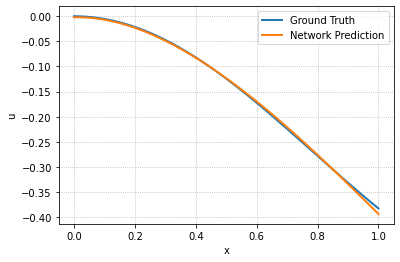

In [16]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, h_test, label="Ground Truth",lw=2)
plt.plot(x_test, h_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [17]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((h_test_pred - h_test)**2)/torch.mean(h_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.021610491967294365 %


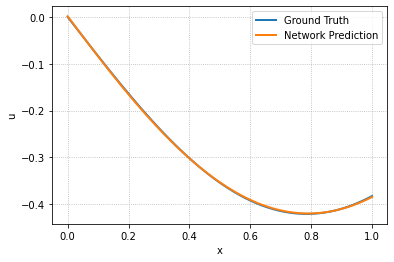

In [18]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, e1_test, label="Ground Truth",lw=2)
plt.plot(x_test, e1_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [19]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((e1_test_pred - e1_test)**2)/torch.mean(e1_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.0011403158168832306 %


In [20]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((e2_test_pred - e2_test)**2)/torch.mean(e2_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.008678590529598296 %


In [21]:
# for ploting

In [22]:
model = my_network
x_test = pi*torch.rand(100000).reshape(-1,1)
t_test = torch.rand(100000).reshape(-1,1)
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test,t_test).reshape(-1,1)
p_test = exact_solution_p(x_test,t_test).reshape(-1,1)
u_test_pred = my_network(test)
u_pred = u_test_pred[:, 0].reshape(-1,1)

u_pred1 = u_test_pred[:, 1].reshape(-1,1)


relative_error = torch.abs(u_pred- u_test)

relative_error1 = torch.abs(u_pred1- p_test)
u_pred = u_pred.detach().numpy()
x_test = x_test.detach().numpy()
t_test = t_test.detach().numpy()
p_pred = u_pred1.detach().numpy()
relative_error = relative_error.detach().numpy()
relative_error1 = relative_error1.detach().numpy()

NameError: name 'exact_solution_u' is not defined

In [ ]:

x_test = x_test.reshape(-1,)
t_test = t_test.reshape(-1,)

u_pred = u_pred.reshape(-1,)
p_pred = p_pred.reshape(-1,)

In [ ]:

plt.rcParams['figure.figsize'] = [10, 4]


CS = plt.tricontourf(x_test, t_test, u_pred, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


#plt.savefig('timo_u.png', dpi = 300, bbox_inches = "tight")

In [ ]:
CS = plt.tricontourf(x_test, t_test, p_pred, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('timo_p.png', dpi = 300, bbox_inches = "tight")

In [ ]:

x_test = x_test.reshape(-1, )
t_test = t_test.reshape(-1, )
relative_error = relative_error.reshape(-1,)




CS = plt.tricontourf(x_test, t_test, relative_error, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('relative_error_timo_u.png', dpi = 300, bbox_inches = "tight")

In [ ]:
relative_error1 = relative_error1.reshape(-1,)

CS = plt.tricontourf(x_test, t_test, relative_error1, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('relative_error_timo_p.png', dpi = 300, bbox_inches = "tight")